<a href="https://colab.research.google.com/github/salilathalye/chats-with-austin/blob/main/CWA_Try_PyCaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1>Conversations with Austin</H1>
<h2>Try PyCaret
<p>I've been waiting for a while to take PyCaret out for a spin and proverbially kick the tires. I started out with an imbalanced dataset with some missing values with the aim of building a binary classifier. I'm working on some deep dives into math/theory and so this will be a nice test bed to try things out and see the results.

Salil Athalye
www.bokehboy.com


Data provided by [DPhi Tech](https://dphi.tech//) Assignment 3: Advanced: Loan or No Loan?
https://dphi.tech/practice/challenge/54


# Install Packages


In [1]:
!pip install pycaret --quiet
!pip install mlflow --quiet
!pip install pyngrok --quiet
!pip install shap --quiet

     |████████████████████████████████| 71kB 3.2MB/s 


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn


# PyCaret
import pycaret
print(f'PyCaret version: {pycaret.__version__}')
from pycaret.classification import * 
from pycaret.utils import enable_colab
enable_colab()
from pyngrok import ngrok

# MLflow
import mlflow
print(f'MLflow version: {mlflow.__version__}')

#TODO: How to set up an MLflow server which we can use with Colab? 
#mlflow.set_tracking_uri('file:/c:/users/mlflow-server')

import shap
#TODO: Not sure how PyCaret sets up shap.init_js() which is required for CoLab.

PyCaret version: 2.2.0
Colab mode enabled.
MLflow version: 1.13


# Experiment Parameters


In [3]:
EXPERIMENT_NAME = 'dphi_ch54_1'
SESSION_ID = 3435
TRAINING_DATA = "loan_train.csv"
TEST_DATA = "loan_test.csv"
TARGET_COL = 'Loan_Status'

# Load the data


In [4]:
# Dataset is provided by DPhi
# raw.githubusercontent.com allows us to download 'raw' content of files stored on github

training_data  = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_train.csv", index_col=[0])
test_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_test.csv')

# Save the raw data in case the source is unavailable later
training_data.to_csv(TRAINING_DATA, index=False)
test_data.to_csv(TEST_DATA, index=False)



###Data Description
* Loan_ID: A unique ID assigned to every loan applicant
* Gender: Gender of the applicant (Male, Female)
* Married: The marital status of the applicant (Yes, No)
* Dependents: No. of people dependent on the applicant (0,1,2,3+)
* Education: Education level of the applicant (Graduated, Not Graduated)
* Self_Employed: If the applicant is self-employed or not (Yes, No)
* ApplicantIncome: The amount of income the applicant earns
* CoapplicantIncome: The amount of income the co-applicant earns
* LoanAmount: The amount of loan the applicant has requested for
* Loan_Amount_Term: The  no. of days over which the loan will be paid
* Credit_History: A record of a borrower's responsible repayment of debts (1- has all debts paid, 0- not paid)
* Property_Area : The type of location where the applicant’s property lies (Rural, Semiurban, Urban)
* Loan_Status: Loan granted or not (Y, N)




In [5]:
test_data.shape

(123, 12)

In [6]:
training_data.shape

(491, 13)

In [7]:
test_data_columns = test_data.columns
training_data_columns = training_data.columns
#Set difference : columns in training_data that are not in test_data
columns_missing = set(training_data_columns) - set(test_data_columns)
print(columns_missing)

{'Loan_Status'}


In [8]:
training_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [9]:
training_data.head(5)

Loan_ID  Gender Married Dependents     Education Self_Employed  \
0  LP002305  Female      No          0      Graduate            No   
1  LP001715    Male     Yes         3+  Not Graduate           Yes   
2  LP002086  Female     Yes          0      Graduate            No   
3  LP001136    Male     Yes          0  Not Graduate           Yes   
4  LP002529    Male     Yes          2      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             4547                0.0       115.0             360.0   
1             5703                0.0       130.0             360.0   
2             4333             2451.0       110.0             360.0   
3             4695                0.0        96.0               NaN   
4             6700             1750.0       230.0             300.0   

   Credit_History Property_Area  Loan_Status  
0             1.0     Semiurban            1  
1             1.0         Rural            1  
2             1.0         Urban            0  
3             1.0         Urban            1  
4             1.0     Semiurban            1

In [10]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491 entries, 0 to 490
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            491 non-null    object 
 1   Gender             481 non-null    object 
 2   Married            490 non-null    object 
 3   Dependents         482 non-null    object 
 4   Education          491 non-null    object 
 5   Self_Employed      462 non-null    object 
 6   ApplicantIncome    491 non-null    int64  
 7   CoapplicantIncome  491 non-null    float64
 8   LoanAmount         475 non-null    float64
 9   Loan_Amount_Term   478 non-null    float64
 10  Credit_History     448 non-null    float64
 11  Property_Area      491 non-null    object 
 12  Loan_Status        491 non-null    int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 53.7+ KB


In [11]:
training_data.isna().sum()

Loan_ID               0
Gender               10
Married               1
Dependents            9
Education             0
Self_Employed        29
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           16
Loan_Amount_Term     13
Credit_History       43
Property_Area         0
Loan_Status           0
dtype: int64

In [12]:
training_data.describe()

ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       491.000000         491.000000  475.000000        478.000000   
mean       5401.189409        1589.730998  145.014737        341.297071   
std        6419.427177        2919.320624   86.310534         66.964051   
min         150.000000           0.000000   17.000000         12.000000   
25%        2923.500000           0.000000  100.000000        360.000000   
50%        3865.000000        1229.000000  126.000000        360.000000   
75%        5705.500000        2251.500000  162.000000        360.000000   
max       81000.000000       41667.000000  700.000000        480.000000   

       Credit_History  Loan_Status  
count      448.000000   491.000000  
mean         0.848214     0.698574  
std          0.359214     0.459345  
min          0.000000     0.000000  
25%          1.000000     0.000000  
50%          1.000000     1.000000  
75%          1.000000     1.000000  
max          1.000000     1.000000

In [13]:
training_data[TARGET_COL].value_counts()

1    343
0    148
Name: Loan_Status, dtype: int64

# Perform Basic Exploratory Data Analysis

#PyCaret

## Set up the Experiment

In [14]:
experiment = setup(training_data, 
                    target = TARGET_COL, 
                    session_id=SESSION_ID, 
                    ignore_features=['Loan_ID'],
                    imputation_type="iterative", 
                    categorical_iterative_imputer="lightgbm", 
                    numeric_iterative_imputer="lightgbm", 
                    iterative_imputation_iters = 5,
                    normalize = True,
                    fix_imbalance = True,
                    fix_imbalance_method = None, # will use SMOTE by default 
                    log_experiment = True, 
                    experiment_name = EXPERIMENT_NAME)


Description                            Value
0                               session_id                             3435
1                                   Target                      Loan_Status
2                              Target Type                           Binary
3                            Label Encoded                       0: 0, 1: 1
4                            Original Data                        (491, 13)
5                           Missing Values                             True
6                         Numeric Features                                3
7                     Categorical Features                                8
8                         Ordinal Features                            False
9                High Cardinality Features                            False
10                 High Cardinality Method                             None
11                   Transformed Train Set                        (343, 24)
12                    Transformed Test Set                        (148, 24)
13                      Shuffle Train-Test                             True
14                     Stratify Train-Test                            False
15                          Fold Generator                  StratifiedKFold
16                             Fold Number                               10
17                                CPU Jobs                               -1
18                                 Use GPU                            False
19                          Log Experiment                             True
20                         Experiment Name                      dphi_ch54_1
21                                     USI                             c11c
22                         Imputation Type                        iterative
23          Iterative Imputation Iteration                                5
24                         Numeric Imputer                             mean
25      Iterative Imputation Numeric Model  Light Gradient Boosting Machine
26                     Categorical Imputer                         constant
27  Iterative Imputation Categorical Model  Light Gradient Boosting Machine
28           Unknown Categoricals Handling                   least_frequent
29                               Normalize                             True
30                        Normalize Method                           zscore
31                          Transformation                            False
32                   Transformation Method                             None
33                                     PCA                            False
34                              PCA Method                             None
35                          PCA Components                             None
36                     Ignore Low Variance                            False
37                     Combine Rare Levels                            False
38                    Rare Level Threshold                             None
39                         Numeric Binning                            False
40                         Remove Outliers                            False
41                      Outliers Threshold                             None
42                Remove Multicollinearity                            False
43             Multicollinearity Threshold                             None
44                              Clustering                            False
45                    Clustering Iteration                             None
46                     Polynomial Features                            False
47                       Polynomial Degree                             None
48                    Trignometry Features                            False
49                    Polynomial Threshold                             None
50                          Group Features                            False
51                       Feature Selection                            False
52 

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


## Compare Models

In [15]:
# return best model based on F1
best = compare_models(sort = 'F1', fold=5) #default is 'Accuracy'

Model  Accuracy     AUC  Recall   Prec.  \
catboost              CatBoost Classifier    0.7785  0.7156  0.9197  0.7937   
gbc          Gradient Boosting Classifier    0.7726  0.7237  0.9070  0.7941   
rf               Random Forest Classifier    0.7668  0.7103  0.8939  0.7943   
ridge                    Ridge Classifier    0.7580  0.0000  0.8899  0.7880   
lda          Linear Discriminant Analysis    0.7520  0.7033  0.8814  0.7866   
xgboost         Extreme Gradient Boosting    0.7552  0.6960  0.8561  0.8048   
lr                    Logistic Regression    0.7493  0.7196  0.8561  0.7970   
lightgbm  Light Gradient Boosting Machine    0.7435  0.6992  0.8519  0.7945   
et                 Extra Trees Classifier    0.7347  0.7070  0.8558  0.7807   
ada                  Ada Boost Classifier    0.7347  0.6855  0.8475  0.7857   
dt               Decision Tree Classifier    0.6999  0.6448  0.7926  0.7783   
qda       Quadratic Discriminant Analysis    0.6117  0.5259  0.7830  0.7076   
knn                K Neighbors Classifier    0.4984  0.4741  0.5508  0.6633   
svm                   SVM - Linear Kernel    0.5373  0.0000  0.6000  0.4127   
nb                            Naive Bayes    0.3411  0.6881  0.0551  0.7933   

              F1   Kappa     MCC  TT (Sec)  
catboost  0.8511  0.4272  0.4504     2.044  
gbc       0.8460  0.4181  0.4347     0.128  
rf        0.8409  0.4104  0.4201     0.554  
ridge     0.8353  0.3857  0.3969     0.030  
lda       0.8303  0.3746  0.3859     0.030  
xgboost   0.8284  0.4023  0.4078     0.882  
lr        0.8248  0.3861  0.3908     0.724  
lightgbm  0.8209  0.3695  0.3747     0.066  
et        0.8157  0.3435  0.3519     0.550  
ada       0.8148  0.3495  0.3544     0.124  
dt        0.7839  0.2902  0.2922     0.032  
qda       0.6862  0.0162  0.0362     0.032  
knn       0.6017 -0.0614 -0.0633     0.154  
svm       0.4890  0.0000  0.0000     0.028  
nb        0.1025  0.0172  0.0549     0.030

## Select the Base Model

In [16]:
# train base model
base_model = create_model('catboost')


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7714  0.7311  0.8333  0.8333  0.8333  0.4697  0.4697
1       0.8000  0.8485  0.9167  0.8148  0.8627  0.4990  0.5109
2       0.8000  0.7462  0.9167  0.8148  0.8627  0.4990  0.5109
3       0.6176  0.5208  0.8333  0.6897  0.7547 -0.0780 -0.0858
4       0.8824  0.8667  1.0000  0.8571  0.9231  0.6792  0.7171
5       0.7353  0.6083  0.9167  0.7586  0.8302  0.2537  0.2787
6       0.8235  0.7708  1.0000  0.7931  0.8846  0.5300  0.6004
7       0.7059  0.5692  0.8261  0.7600  0.7917  0.2946  0.2976
8       0.7941  0.6482  0.9565  0.7857  0.8627  0.4664  0.5045
9       0.7941  0.7708  0.8696  0.8333  0.8511  0.5182  0.5195
Mean    0.7724  0.7080  0.9069  0.7941  0.8457  0.4132  0.4324
SD      0.0685  0.1107  0.0623  0.0462  0.0447  0.1993  0.2112

## Tune the Model

In [17]:
# tune hyperparameters to optimize F1
tuned_model = tune_model(base_model, optimize = 'F1')


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8286  0.8220  0.9583  0.8214  0.8846  0.5588  0.5847
1       0.8571  0.8902  1.0000  0.8276  0.9057  0.6220  0.6719
2       0.7714  0.7348  0.9583  0.7667  0.8519  0.3778  0.4271
3       0.7059  0.5458  0.9583  0.7188  0.8214  0.0761  0.1130
4       0.8824  0.9042  1.0000  0.8571  0.9231  0.6792  0.7171
5       0.7353  0.6688  0.9583  0.7419  0.8364  0.1990  0.2544
6       0.8235  0.8142  1.0000  0.7931  0.8846  0.5300  0.6004
7       0.7353  0.6285  0.8696  0.7692  0.8163  0.3489  0.3575
8       0.7647  0.6996  1.0000  0.7419  0.8519  0.3366  0.4498
9       0.8235  0.7905  0.9565  0.8148  0.8800  0.5546  0.5808
Mean    0.7928  0.7499  0.9659  0.7853  0.8656  0.4283  0.4757
SD      0.0554  0.1096  0.0377  0.0424  0.0338  0.1838  0.1824

## Review Model Diagnostics

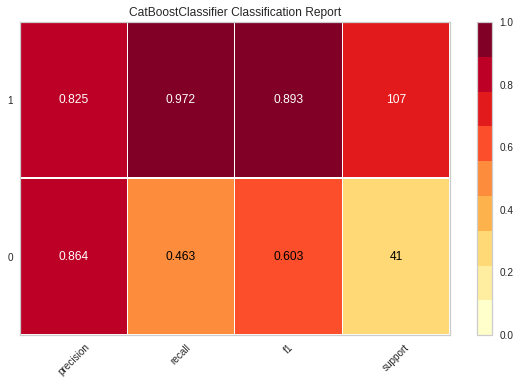

In [18]:
plot_model(tuned_model, plot = 'class_report')

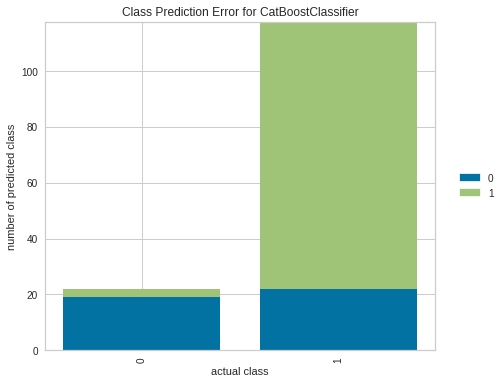

In [19]:
plot_model(tuned_model, plot='error')

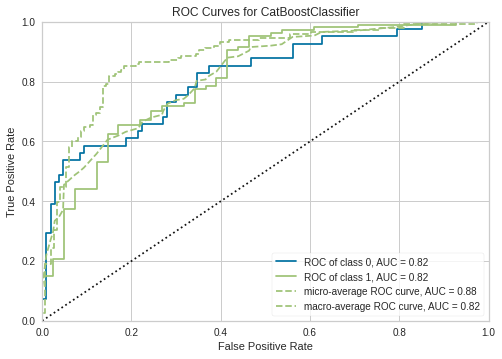

In [20]:
#plot a model
plot_model(tuned_model, plot='auc')

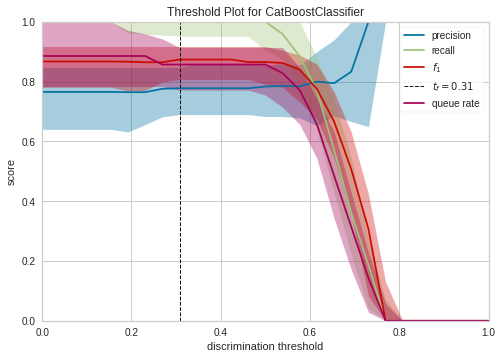

In [21]:
plot_model(tuned_model, plot='threshold')

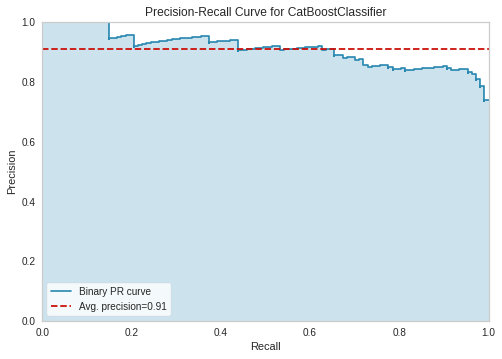

In [22]:
plot_model(tuned_model, plot = 'pr')

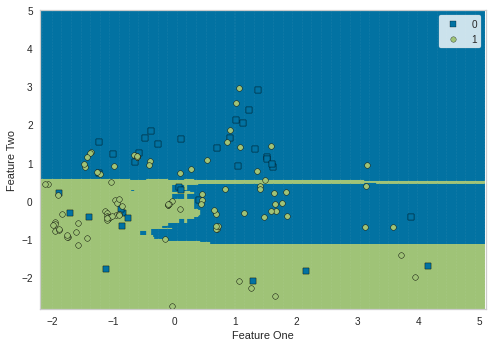

In [23]:
plot_model(tuned_model, plot='boundary')

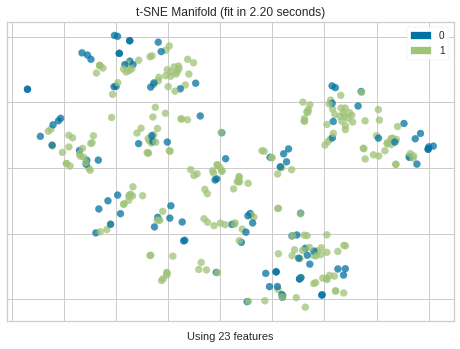

In [24]:
plot_model(tuned_model, plot='manifold')

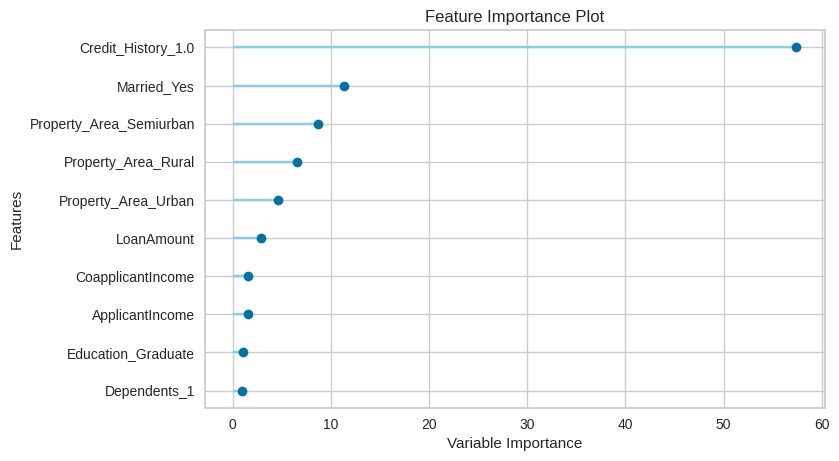

In [25]:

plot_model(tuned_model, plot='feature')

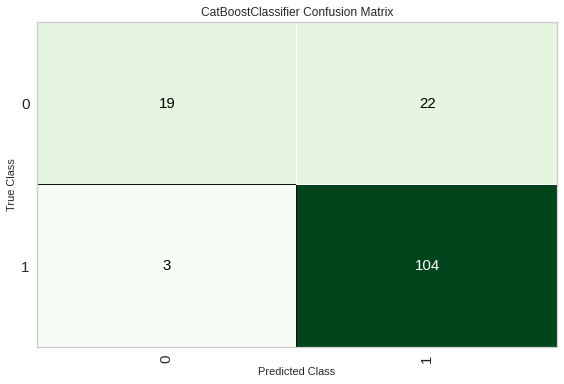

In [26]:
plot_model(tuned_model, plot = 'confusion_matrix')

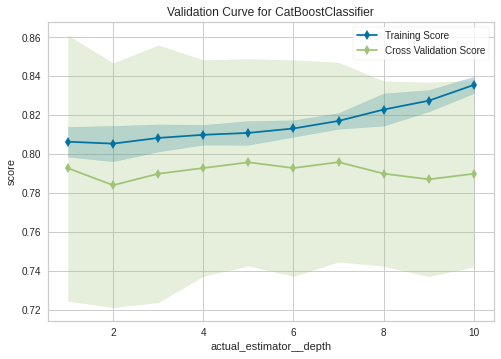

In [27]:
plot_model(tuned_model, plot='vc')

In [28]:
predict_model(tuned_model)


Model  Accuracy     AUC  Recall   Prec.      F1  Kappa     MCC
0  CatBoost Classifier    0.8311  0.8156   0.972  0.8254  0.8927  0.508  0.5477

ApplicantIncome  CoapplicantIncome  LoanAmount  ...  Loan_Status  Label   Score
0          -0.548585           0.075210        74.0  ...            1      1  0.5768
1           0.065044           1.184896       187.0  ...            1      1  0.7575
2          -0.202069          -0.503953       124.0  ...            1      1  0.5963
3          -0.198082          -0.503953       115.0  ...            1      1  0.6649
4           0.064213          -0.503953       128.0  ...            1      1  0.6997
..               ...                ...         ...  ...          ...    ...     ...
143         0.501096           0.621946       187.0  ...            1      1  0.5266
144        -0.267851           0.096527       120.0  ...            1      1  0.6488
145        -0.052566          -0.503953       132.0  ...            1      1  0.5344
146        -0.258216          -0.003753       135.0  ...            1      1  0.5463
147        -0.301738          -0.178793       135.0  ...            1      1  0.6832

[148 rows x 27 columns]

##Interpret Model Predictions
<p>
If you are viewing this notebook on github, the next set of plots will not render as they require Javascript.

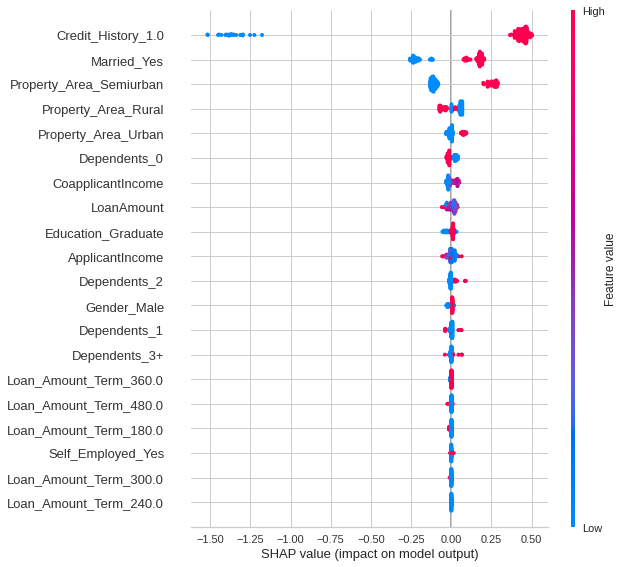

In [30]:
shap.initjs()
interpret_model(tuned_model)

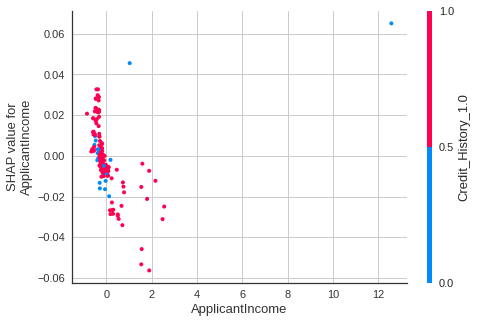

In [31]:
shap.initjs()
interpret_model(tuned_model, plot='correlation')

In [34]:
interpret_model(tuned_model, plot='reason', observation = 77)

In [35]:
interpret_model(tuned_model, plot='reason')

In [37]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Finalize the Model

In [38]:
final_model = finalize_model(tuned_model)

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


In [39]:
print(final_model)

In [40]:
save_model(final_model,'final_model')

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['Loan_ID'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Loan_Status', time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type='gbdt',
                                                              class_weight=None,
                                                              co...
                 ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Loan_Status')),
                 ('fix_perfect', 

In [41]:
!ls

catboost_info	 loan_test.csv	 logs.log  sample_data
final_model.pkl  loan_train.csv  mlruns


# Load Model and Predict


In [42]:
loaded_model = load_model('final_model')

Transformation Pipeline and Model Successfully Loaded


In [43]:
loaded_model

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True,
                                      features_todrop=['Loan_ID'],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='Loan_Status', time_features=[])),
                ('imputer',
                 Iterative_Imputer(add_indicator=False,
                                   classifier=LGBMClassifier(boosting_type='gbdt',
                                                             class_weight=None,
                                                             co...
                ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='Loan_Status')),
                ('fix_perfect', Remove_100(target

In [44]:
single_example = test_data.iloc[[1],:]

In [45]:
prediction = predict_model(loaded_model, data= single_example)

In [46]:
prediction

Loan_ID Gender Married  ... Property_Area Label   Score
1  LP001488   Male     Yes  ...     Semiurban     1  0.7544

[1 rows x 14 columns]

In [47]:
batch_prediction = predict_model(loaded_model, data=test_data)

In [48]:
batch_prediction

Loan_ID  Gender Married  ... Property_Area Label   Score
0    LP001116    Male      No  ...     Semiurban     1  0.7192
1    LP001488    Male     Yes  ...     Semiurban     1  0.7544
2    LP002138    Male     Yes  ...         Rural     1  0.6271
3    LP002284    Male      No  ...         Rural     1  0.5420
4    LP002328    Male     Yes  ...         Rural     0  0.8141
..        ...     ...     ...  ...           ...   ...     ...
118  LP002683    Male      No  ...     Semiurban     1  0.7424
119  LP002054    Male     Yes  ...         Rural     1  0.6068
120  LP002757  Female     Yes  ...     Semiurban     1  0.7239
121  LP002582  Female      No  ...     Semiurban     1  0.6487
122  LP001616    Male     Yes  ...     Semiurban     1  0.7558

[123 rows x 14 columns]

In [49]:
submission = batch_prediction[['Label']]
submission.rename(columns={'Label':'prediction'}, inplace=True)
submission.index = test_data.index
submission.to_csv('prediction_results.csv', index=False)

In [50]:
logs = get_logs(save=True)
logs.head()

run_id  ... tags.Run Time
0  5ac7ff3a069348848d7f0bf14cd23f56  ...          1.92
1  c20e66a0f4c546829933be330d912f43  ...         59.49
2  9047b60a5b74406dace9c4427a5f8034  ...         23.63
3  6ac18a10fe1145a780935de1faf9a89b  ...          0.36
4  6e7f9a8b96f342f7910f586c8505351a  ...          0.34

[5 rows x 205 columns]

# Bundle Outputs and Download

In [51]:
# Google Colab places a folder of sample data in sample_data. We don't need that.
!rm -rf sample_data ||:


In [52]:
ZIP_ARCHIVE_NAME = EXPERIMENT_NAME + '.zip'


In [53]:
!zip -qr ./$ZIP_ARCHIVE_NAME ./

In [54]:
from google.colab import files
files.download(ZIP_ARCHIVE_NAME)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>